## Gibbs sampler code


## Python Imports

In [3]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from time import time

%matplotlib inline

## Data imports

## DEFINE THE PATH TO YOUR COURSE DIRECTORY

In [4]:
data_dir = "/home/mathias/bioinfo_algos/data/"

In [5]:
alphabet_file = data_dir + "Matrices/alphabet"
alphabet = np.loadtxt(alphabet_file, dtype=str)

#alphabet

bg_file = data_dir + "Matrices/bg.freq.fmt"
_bg = np.loadtxt(bg_file, dtype=float)

bg = {}
for i in range(0, len(alphabet)):
    bg[alphabet[i]] = _bg[i]

bg

blosum_file = data_dir + "Matrices/blosum62.freq_rownorm"
_blosum62 = np.loadtxt(blosum_file, dtype=float).reshape((20, 20)).T

blosum62 = {}

for i, letter_1 in enumerate(alphabet):
    
    blosum62[letter_1] = {}

    for j, letter_2 in enumerate(alphabet):
        
        blosum62[letter_1][letter_2] = _blosum62[i, j]

#blosum62

## Calculate log-odd matrix from a given peptide core alignment

In [6]:
def initialize_matrix(core_len, alphabet):

    init_matrix = [0]*core_len

    for i in range(0, core_len):

        row = {}

        for letter in alphabet: 
            row[letter] = 0.0

        #fancy way:  row = dict( zip( alphabet, [0.0]*len(alphabet) ) )

        init_matrix[i] = row
        
    return init_matrix



def put_to_zero(matrix):
    
    for i in range(0, len(matrix)):

        for key in matrix[i].keys():
        
            matrix[i][key] = 0.0
    
    return matrix


            
def get_log_odds(peptides, alphabet, bg, scoring_scheme, core_len, c_matrix, f_matrix, g_matrix, p_matrix, w_matrix):

    # Amino Acid Count Matrix (c)

    c_matrix = put_to_zero(c_matrix)

    for position in range(0, core_len):

        # peptides has two elements; element[0] is the peptide sequence, element [1] is the core location
        for element in peptides:
            
            peptide = element[0]
            
            core_start = element[1]
            
            c_matrix[position][peptide[core_start+position]] += 1

            
    # Sequence Weighting
    weights = {}
    sequence_weighting = True
    #sequence_weighting = False

    for element in peptides:

        peptide = element[0]
        core_start = element[1]
            
        # apply sequence weighting
        if sequence_weighting:

            w = 0.0
            neff = 0.0

            for position in range(0, core_len):

                r = 0

                for letter in alphabet:        

                    if c_matrix[position][letter] != 0:

                        r += 1

                s = c_matrix[position][peptide[core_start+position]]

                w += 1.0/(r * s)

                neff += r

            neff = neff / core_len

        # do not apply sequence weighting
        else:

            w = 1  

            neff = len(peptides)  


        weights[peptide] = w

    
    # Observed Frequencies Matrix (f)
    f_matrix = put_to_zero(f_matrix)

    for position in range(0, core_len):

        n = 0;

        for element in peptides:

            peptide = element[0]
            
            core_start = element[1]
              
            f_matrix[position][peptide[core_start+position]] += weights[peptide]

            n += weights[peptide]

        for letter in alphabet: 

            f_matrix[position][letter] = f_matrix[position][letter]/n

    
    # Pseudo Frequencies Matrix (g)
    g_matrix = put_to_zero(g_matrix)

    for position in range(0, core_len):

        for letter_1 in alphabet:
            
            for letter_2 in alphabet:

                 g_matrix[position][letter_1] += f_matrix[position][letter_2] * scoring_scheme[letter_1][letter_2]

                    
    # Combined Frequencies Matrix (p)

    alpha = neff - 1
    beta = 50

    for position in range(0, core_len):

        for letter in alphabet:

            num = alpha*f_matrix[position][letter] + beta*g_matrix[position][letter]
            
            den = alpha + beta

            p_matrix[position][letter] = num / den
        

    # Log Odds Weight Matrix (w)
    for position in range(0, core_len):

        for letter in alphabet:

            if p_matrix[position][letter] != 0:
                
                w_matrix[position][letter] = math.log(p_matrix[position][letter]/bg[letter])/math.log(2)
    
    # Calculate the overall score of the peptides to the LO matrix
    _sum = 0
    for position in range(0, core_len):
        for letter in alphabet:
            _sum += f_matrix[position][letter] * w_matrix[position][letter]
    
    return w_matrix, _sum, p_matrix

## Score peptides to matrix

In [7]:
def score_peptide(peptide, core_start, core_len, matrix):
    acum = 0
    for i in range(0, core_len):
        acum += matrix[i][peptide[i+core_start]]
    return acum

## Read peptides

In [8]:
def load_peptide_data():
    
    peptides_file = data_dir + "Gibbs/DRB10401.lig"
    
    # Remove peptides shorter than core_len
    raw_peptides = np.loadtxt(peptides_file, dtype=str).tolist()

    # only keep peptides with length equal to or longer than core_len
    peptides = []
    for i in range(0, len(raw_peptides)):
        if len(raw_peptides[i]) >= core_len:          
            peptides.append(raw_peptides[i])
        else:
            print ("Peptide length too short discard", raw_peptides[i])

    peptides
    
    peptides = sorted(peptides, key=len)
    min_pep_len = len(peptides[0])
    max_pep_len = len(peptides[-1])

    # random core start
    np.random.shuffle(peptides)
    cores_start = [0]*len(peptides)

    random.seed( 1 )

    for i in range(0, len(cores_start)):

        if len(peptides[i]) != core_len:

            min_core_start = 0
            max_core_start = len(peptides[i]) - core_len

            cores_start[i] = random.randint(min_core_start, max_core_start)

    peptides = list(zip(peptides, cores_start))

    return peptides, min_pep_len, core_len

## Print out w-matrix in Psi_blast format

In [9]:
def to_psi_blast(matrix):

    header = ["", "A", "R", "N", "D", "C", "Q", "E", "G", "H", "I", "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"]

    print('{:>4} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8}'.format(*header)) 

    letter_order = ["A", "R", "N", "D", "C", "Q", "E", "G", "H", "I", "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"]

    for i, row in enumerate(matrix):

        scores = []

        scores.append(str(i+1) + " A")

        for letter in letter_order:

            score = row[letter]

            scores.append(round(score, 4))

        print('{:>4} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8}'.format(*scores)) 


## Define run parameters

In [10]:
def initialize():
    
    # define M temperature steps, from T_i to T_f

    #core_len = min_pep_len
    core_len = 9

    T_i = 0.1
    T_f = 0.0001
    T_steps = 10
    T_delta = (T_f - T_i) / T_steps
    
    T = np.linspace(T_i,T_f,T_steps )
    iters_per_point = 4
    iters = len(peptides)*iters_per_point

    return T, iters

## Main loop

In [11]:
#core_len = min_pep_len
core_len = 9

peptides, min_pep_len, core_len = load_peptide_data()
T, iters = initialize()

c_matrix = initialize_matrix(core_len, alphabet)
f_matrix = initialize_matrix(core_len, alphabet)
g_matrix = initialize_matrix(core_len, alphabet)
p_matrix = initialize_matrix(core_len, alphabet)
w_matrix = initialize_matrix(core_len, alphabet)

np.random.seed( 1 ) 

log_odds_matrix, peptide_scores, _ = get_log_odds(peptides, alphabet, bg, blosum62, core_len, c_matrix, f_matrix, g_matrix, p_matrix, w_matrix)

debug = False
#debug = True

kld = []

print( "Initial KLD score: " + str(peptide_scores))
kld.append( peptide_scores )

t0 = time()

for t in T:

    for i in range(0, iters):
            
        # extract peptide
        rand_index = random.randint(0,len(peptides)-1)
        peptide = peptides[rand_index][0]
        core_start_original = peptides[rand_index][1]

        # print stuff
        if debug:
            print("")
            print("------------")
            print("T: " + str(t) + ", i: " + str(i))
            print("------------")
            print("Peptide: " + str(peptide)),
            print("Core start: " + str(core_start_original) + " (" + peptide[core_start_original:core_start_original+core_len] + ")")


        if len(peptide) != core_len:
                
            max_core_start = len(peptide) - core_len

            core_start_shifted = random.randint(0, max_core_start)
                 
            #if debug: print("Shifted core start: " + str(peptide) + " " + str(core_start_shifted) + " (" + peptide[core_start_shifted:core_start_shifted+core_len] +")")
                
            # remove peptide from list
            peptides.remove(peptides[rand_index])

            # get base log_odds
            log_odds_matrix, peptide_scores, p_matrix = get_log_odds(peptides, alphabet, bg, blosum62, core_len, c_matrix, f_matrix, g_matrix, p_matrix, w_matrix)
            #pprint(log_odds_matrix)
                
            # score peptide against log_odds
            e_original = score_peptide(peptide, core_start_original, core_len, log_odds_matrix)
            if debug: print("Energy before shifting: " + str(e_original))

            # score shifted peptide against log_odds
            e_shift = score_peptide(peptide, core_start_shifted, core_len, log_odds_matrix)
            if debug: print("Energy after shifting: " + str(e_shift))

            # energy differential
            de = e_shift - e_original
            if debug: print("Energy differential: " + str(de))
    
            # probability of accepting move
            if ( de > 0):
                p = 1
            else:
                p = np.exp(de/t)
        
            if debug: print("Probability of shifting peptide: " + str(p))
    
            # throw coin
            coin = np.random.uniform(0.0, 1.0, 1)[0]
            if debug: print("RNG: " + str(coin))

            if coin < p:
                if debug: print("RNG < P, Move accepted")
                peptides.append((peptide, core_start_shifted))
                kld.append(peptide_scores)

            else:
                if debug: print("RNG >= P, Move rejected")
                peptides.append((peptide, core_start_original))      
                      
        else:
            if debug: print("Can't shift peptide, it is a " + str(core_len) + "mer")
              
    print( "KLD score t: " + str(t) + " KLD: " + str(peptide_scores))
    
t1 = time()

print("Time elapsed (m):", (t1-t0)/60)

Initial KLD score: 0.6600173084734622
KLD score t: 0.1 KLD: 1.8274826017250168
KLD score t: 0.0889 KLD: 2.399142948932986
KLD score t: 0.07780000000000001 KLD: 2.761925930275793
KLD score t: 0.06670000000000001 KLD: 3.000094102281901
KLD score t: 0.055600000000000004 KLD: 3.1737338970430864
KLD score t: 0.044500000000000005 KLD: 3.2973978424396786
KLD score t: 0.0334 KLD: 3.3740724684460943
KLD score t: 0.0223 KLD: 3.389349818305951
KLD score t: 0.011200000000000002 KLD: 3.411514045709288
KLD score t: 0.0001 KLD: 3.4303128431403622
Time elapsed (m): 12.430475425720214


## Plot KLD curve

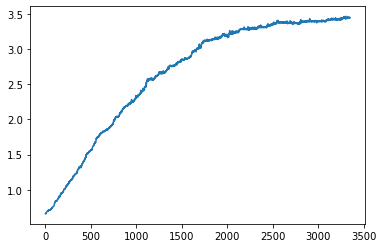

In [12]:
x = np.arange(0,len(kld))
plt.plot(x,kld)
plt.show()

## Write out PSSM matrix

In [13]:
to_psi_blast(log_odds_matrix)

            A        R        N        D        C        Q        E        G        H        I        L        K        M        F        P        S        T        W        Y        V
 1 A  -1.0311  -0.9333  -1.5308  -1.7816  -0.8519  -0.9174  -0.8337   -1.237  -0.1849  -0.1807   0.3796  -0.5841   0.1026   1.8865  -1.8564  -1.0573  -0.9405   2.6338   2.3414  -0.4571
 2 A  -0.0774    0.903  -0.6051  -0.3288  -0.5449  -0.1888  -0.5611  -0.3988   -0.252   0.0923   0.0934   0.1924   0.1153  -0.2983  -0.7441   0.0824  -0.2023   0.1052  -0.2825   0.7245
 3 A   0.3557   0.4023   0.1724  -0.4719  -0.7813    0.351   0.3685  -0.3646    0.066  -0.3563  -0.1864   0.4822  -0.3922  -0.3801   0.2087   0.1858  -0.1517  -0.3109   0.0836  -0.3295
 4 A   0.5378  -0.7048  -0.0229   0.2445  -1.3195   0.9737   0.6272  -0.7478  -0.0849   0.0526  -0.2846  -0.4685   0.8132  -0.0613  -0.6398   0.0064  -0.0486   0.6497  -0.8691  -0.0316
 5 A   0.2657  -0.2986   0.8042   -0.258   0.0533    0.457   0.0074  -0.198

## Scoring peptides to weight matrix

In [14]:
evaluation_file = data_dir + "Gibbs/DRB10401.eval"
evaluation = np.loadtxt(evaluation_file, dtype=str).reshape(-1,3)
evaluation_peptides = evaluation[:, 0]
evaluation_targets = evaluation[:, 1].astype(float)

corelen = 9
predictions = []

npeptides = len(evaluation)

#for peptide in evaluation_peptides:
for k in range(npeptides):
    peptide = evaluation_peptides[k]
    target = evaluation_targets[k]
    max_score = -99;
    core_p1 = -9;
    for i in range(0, len(peptide)-corelen+1):
        score = 0;
        for j in range(0, corelen):
            score += log_odds_matrix[j][peptide[i+j]]
        if ( score > max_score):
            max_score = score
            core_p1 = i
    print (peptide, core_p1, peptide[core_p1:core_p1+corelen], max_score, target)
    predictions.append(max_score)

PRYVKQNTLKLATGM 2 YVKQNTLKL 7.75783119666955 0.340972
TLYLQMNSLRAEDTA 2 YLQMNSLRA 6.476782498931465 1.0
YLQMNSLRAEDTAVY 0 YLQMNSLRA 6.476782498931465 0.919907
NTLYLQMNSLRAEDT 3 YLQMNSLRA 6.476782498931465 1.0
ESSFVMMSAPPAEYK 3 FVMMSAPPA 6.790803115878224 0.375605
FVMMSAPPAEYKLQQ 0 FVMMSAPPA 6.790803115878224 0.412954
SFVMMSAPPAEYKLQ 1 FVMMSAPPA 6.790803115878224 0.415043
GKWYLKAMTADQEVPE 3 YLKAMTADQ 5.638356203135461 0.769569
LGASPYKLGPSPKAR 5 YKLGPSPKA 4.6932948291622605 0.833644
YKLGPSPKARSERPA 0 YKLGPSPKA 4.6932948291622605 0.574684
ERRNKYLEEHPSAGK 5 YLEEHPSAG 4.458154119358627 0.360028
NKYLEEHPSAGKDPK 2 YLEEHPSAG 4.458154119358627 0.433383
TVWAQSADFPQFKPE 2 WAQSADFPQ 5.952956336421285 0.799043
PVVHFFKNIVTPRTPPY 5 FKNIVTPRT 4.7055005369963645 0.671995
DENPVVHFFKNIVTPRTPPP 8 FKNIVTPRT 4.7055005369963645 0.770954
DFREFSRAKGLNQEI 1 FREFSRAKG 5.066943903264827 0.555788
QEALEDFREFSRAKG 6 FREFSRAKG 5.066943903264827 0.363799
IYKASPTLAFPAGVC 1 YKASPTLAF 4.422900857764728 0.640385
ELYYAIYKA

ILLLDYMTSTNTNNS 6 MTSTNTNNS 2.3010380304263665 0.565095
CFHEFLSSKLNKFVS 1 FHEFLSSKL 2.4911297139521515 0.456305
PVKIDNASPASTVHA 1 VKIDNASPA 2.9298563873894388 0.685042
RFFVWGDEVPLLTKF 4 WGDEVPLLT 2.3509454428394156 0.6027
TRLFTIRQEMANRGL 5 IRQEMANRG 2.5287722698604727 0.362136
VVLGLATSPTAEGGK 4 LATSPTAEG 2.9664233279071643 0.495153
KAAVAAAASVPAADK 3 VAAAASVPA 3.3817920366972216 0.378286
PEIWHHLSTLIKQPD 3 WHHLSTLIK 3.5997508562102536 0.775598
CDPKRYFVPIFSEAV 6 FVPIFSEAV 2.8469789609065455 0.808296
QRMMAEIDTDGDGFI 2 MMAEIDTDG 2.695537617991784 0.454624
RFKYLLNVSYLCHLV 3 YLLNVSYLC 2.7107190802202075 0.354086
PKIFFRPTTITANVS 3 FFRPTTITA 2.6732447269892985 0.815511
EKMFVSPTPGQRNPY 1 KMFVSPTPG 2.2932446742727897 0.851153
ANQFNKAISQIQESL 3 FNKAISQIQ 3.004213715839092 0.765983
KVKFGHVSINPADIA 3 FGHVSINPA 3.4265380687783997 0.897756
LIEDYFEALSLQLSG 4 YFEALSLQL 3.777811381455644 0.779285
YFKGNFERLAITKGK 5 FERLAITKG 3.093410296016713 0.575094
EGGAHLVQDDVIPAN 5 LVQDDVIPA 3.4589834685485075 0.53809

SILKWHLHKVVEVPI 1 ILKWHLHKV 0.9212169093724776 0.39534
RFTISRDNSKNTLYL 1 FTISRDNSK 1.087788987857858 0.491352
KNVFDDVVPEKYTIG 6 VVPEKYTIG 0.8578406664374465 0.34849
DLLIEALSAMMLDRL 2 LIEALSAMM 1.3063767731152778 0.590835
VNTLRFLVKNAGYLV 3 LRFLVKNAG 1.3148966502759196 0.517905
SGDVIVKAIGALEDI 4 IVKAIGALE 1.4486273432924517 0.58349
KSAFQSSVASGFIGF 0 KSAFQSSVA 1.046619053040387 0.720728
NKSAFQSSVASGFIG 1 KSAFQSSVA 1.046619053040387 0.603068
YVENGLISRVLDGLV 0 YVENGLISR 1.8982242272592578 0.426783
CTSVVLLSVLQQLRV 3 VVLLSVLQQ 1.7787350761252556 0.348717
NVKCKTPTQLAETID 2 KCKTPTQLA 1.4201044299765924 0.319506
KIGIGVLLTWIGLNS 6 LLTWIGLNS 1.4060355091532535 0.343603
GVTVKDVTITAPGDS 4 KDVTITAPG 3.0307246340859955 0.657512
GSTYYADSVKGRFTI 2 TYYADSVKG 1.043679136046046 0.763565
SIINHKFCNLSDAHK 6 FCNLSDAHK 1.9165035197474578 0.543184
ASNPNYLAILVKYVD 5 YLAILVKYV 1.0622605799797844 0.424226
VFNICQAVTANVNAL 3 ICQAVTANV 0.8589599356722137 0.375354
RQAEPSLYGRHNCRC 0 RQAEPSLYG 2.079143124760013 0.32222
T

AVKPAAEEVKVIPAG 5 AEEVKVIPA 0.5729388973920215 0.13528
SFSCIAIGIITLYLG 5 AIGIITLYL 0.29718168542442763 0.449941
ILGLNKIVRMY 0 ILGLNKIVR -1.5454236269354054 0.400892
GAGAAPLSWSKEIYN 3 AAPLSWSKE -0.6175429589821209 0.045968
GTLHDKKSMGDDHFW 5 KKSMGDDHF 0.052334210984938734 0.0061452
NASHCNEMSWIQSIP 4 CNEMSWIQS 0.020659159949032335 0.220377
LGHRDALEDDLLNRN 2 HRDALEDDL -0.5780442681643749 0.0061452
EIDSADKSGCIHNHD 0 EIDSADKSG 0.03929340467349418 0.0733025
GGGGESFGIVVAWQV 6 FGIVVAWQV -0.6519577604781917 0.0773947
NCNIAPLMVAYMLER 6 LMVAYMLER -0.18550794802873544 0.221779
AAKEDFLGCLVKEIP 5 FLGCLVKEI -1.5629483679254292 0.123191
QVTIAGAKLRSLNLG 0 QVTIAGAKL 0.48103661228890765 0.323196
IPAGELQIIDKIDAA 5 LQIIDKIDA -0.6877215408582464 0.19065
KSSKPLVGPFNFRFM 2 SKPLVGPFN -0.5792837371664601 0.564544
TTEMLSRALKKVPVD 5 SRALKKVPV 0.05448517022392663 0.386664
TCEICALKPKIIYCN 6 LKPKIIYCN -0.926774941915215 0.778909
KVPPGPNITATYGDK 4 GPNITATYG -0.6985731840140963 0.0061452
SSGKNEGTNIYNNNE 2 GKNEGTNIY -0.

PCC:  0.4034870886935821


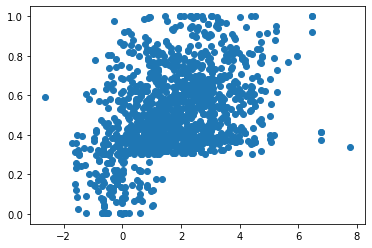

In [15]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

pcc = pearsonr(evaluation_targets, predictions)
print ("PCC: ", pcc[0])

plt.scatter( predictions, evaluation_targets);